## Import modules

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

In [2]:
import session_info
session_info.show()

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, color_map = 'RdPu',)

## Read in data

In [20]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/14Feb_fromSemih/14FebImmuneForKazumasa.h5ad')
print(adata.X.data[:10])
adata

[1. 2. 1. 1. 1. 2. 2. 5. 2. 2.]


AnnData object with n_obs × n_vars = 49042 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', '_scvi_labels', '2Jan_coarse_grain', '2Jan_mid_grain', '2Jan_fine_grain', 'leiden_scVI', 'FACSgate', 'sex', 'week', 'trimester'
    var: 'gene_name_scRNA-0', 'gene_id'
    uns: 'FACSgate_colors', 'age_colors', 'cell_or_nuclei_color

In [7]:
adata.obs['week'].value_counts()

20W    22643
6W      8120
8W      5563
7W      5209
9W      2324
10W     1912
13W     1261
15W     1038
5W       520
14W      207
12W      188
4W        57
Name: week, dtype: int64

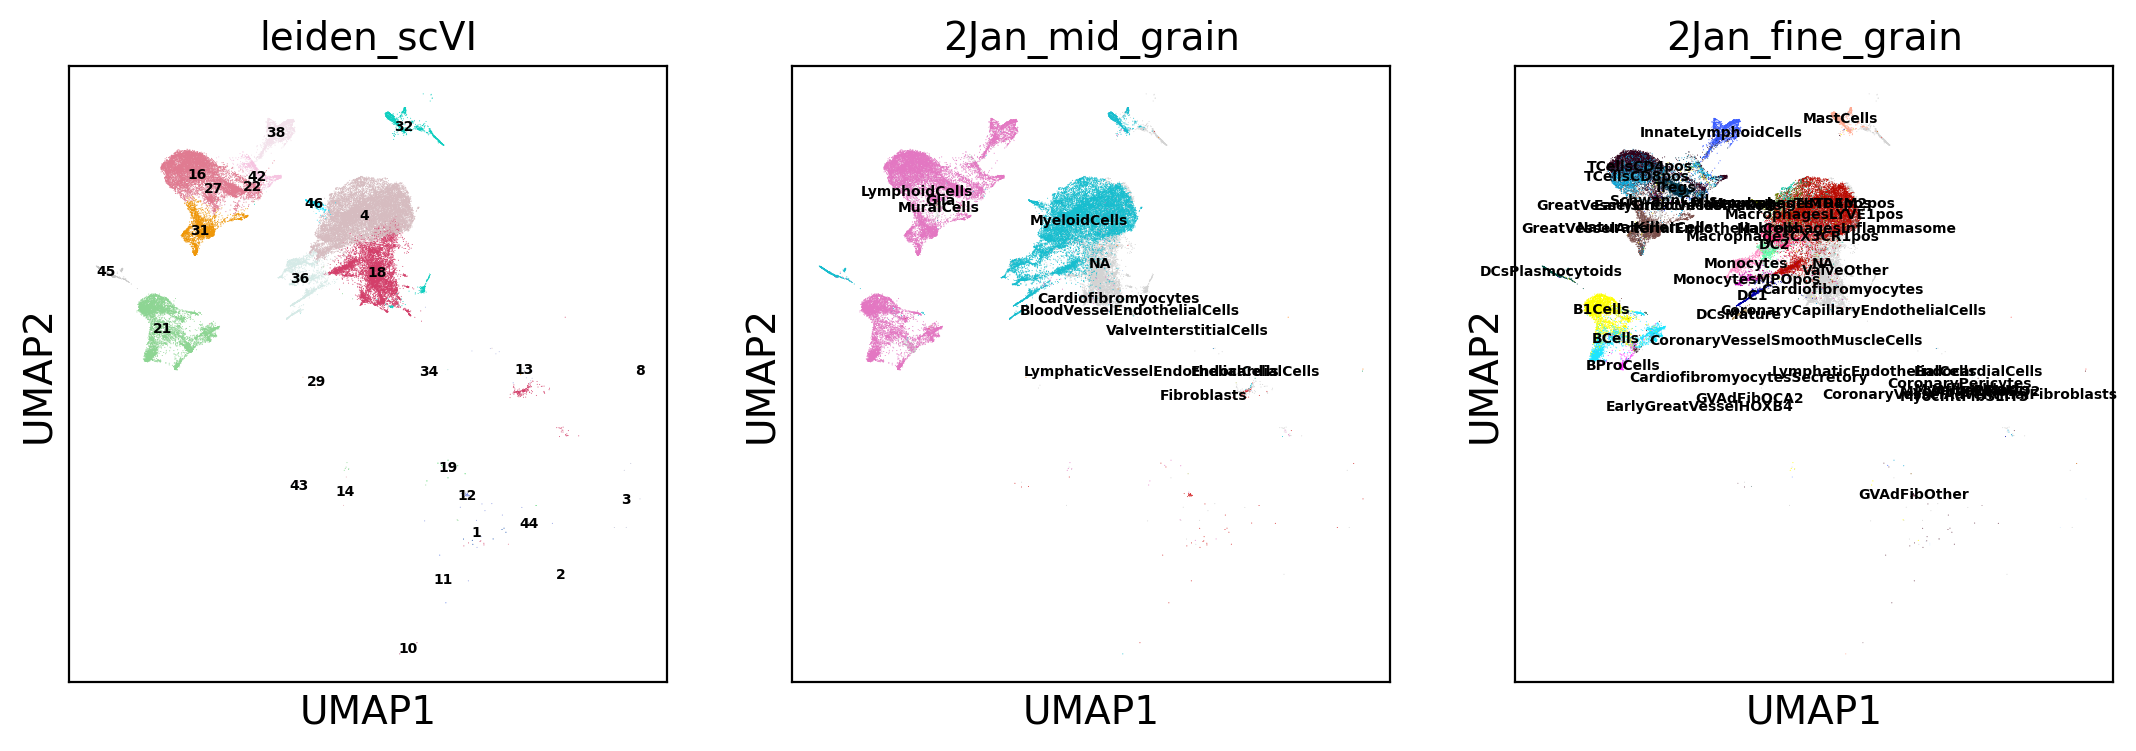

In [9]:
sc.settings.set_figure_params(dpi=200, facecolor='white', color_map = 'RdPu',)
sc.pl.umap(adata, color=['leiden_scVI','2Jan_mid_grain','2Jan_fine_grain'], size=0.5, wspace=0.1, legend_loc='on data', legend_fontsize=5)

## Remove C97: uncertain inflammatory signature in C97

In [11]:
adata_lognorm = adata.copy()
sc.pp.normalize_total(adata_lognorm, target_sum=1e4)
sc.pp.log1p(adata_lognorm)

normalizing counts per cell
    finished (0:00:00)


computing score 'inflammatory'
    finished: added
    'inflammatory', score of gene set (adata.obs).
    200 total control genes are used. (0:00:01)


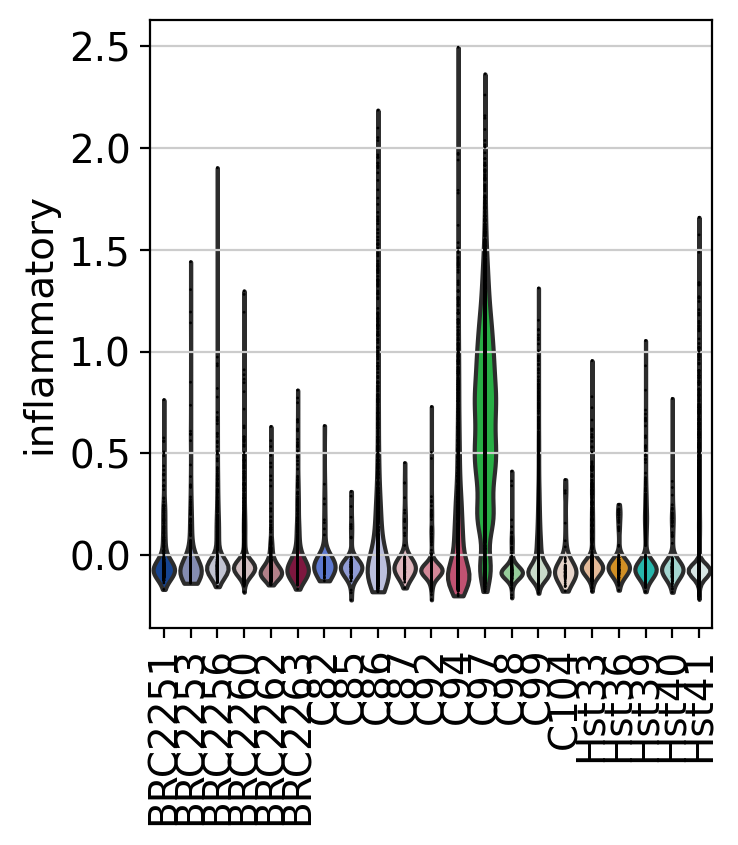

In [12]:
inflam_genes=['TNF','IL1B','IL1A','IL6','CXCL1','CXCL2','CXCL8','CCL2']
inflam_genes = [x for x in inflam_genes if x in adata_lognorm.var_names]
sc.tl.score_genes(adata_lognorm, inflam_genes, score_name='inflammatory')
sc.pl.violin(adata_lognorm, keys='inflammatory', groupby='donor', rotation=90, jitter=False)

In [16]:
!ls /nfs/team205/heart/anndata_objects/Foetal/Immune

In [17]:
# Remove C97 from Immune cells
## save C97 cell ID
C97_index = adata.obs_names[adata.obs['donor']=='C97']
C97_index.to_series().to_csv('/nfs/team205/heart/anndata_objects/Foetal/Immune/C97_index.csv',index=False)

# remove
adata = adata[adata.obs['donor']!='C97']
pd.crosstab(adata.obs['week'],adata.obs['age'])

age,4W3D,5W4D,6W1D,6W5D,7W0D,7W1D,7W3D,7W5D,7W6D,8W4D,8W6D,9W2D,9W3D,10W5D,12W0D,13W0D,14W0D,15W0D,20W0D
week,,,,,,,,,,,,,,,,,,,
4W,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5W,0,520,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6W,0,0,406,553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7W,0,0,0,0,368,392,623,2912,914,0,0,0,0,0,0,0,0,0,0
8W,0,0,0,0,0,0,0,0,0,104,5459,0,0,0,0,0,0,0,0
9W,0,0,0,0,0,0,0,0,0,0,0,105,2219,0,0,0,0,0,0
10W,0,0,0,0,0,0,0,0,0,0,0,0,0,1912,0,0,0,0,0
12W,0,0,0,0,0,0,0,0,0,0,0,0,0,0,188,0,0,0,0
13W,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1261,0,0,0


## Save to gdrive

In [19]:
adata.write(f'/home/jovyan/mount/gdrive/Colab/data/anndata/RNA_foetal_raw_immune_16Feb2023.h5ad')
adata

View of AnnData object with n_obs × n_vars = 41881 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', '_scvi_labels', '2Jan_coarse_grain', '2Jan_mid_grain', '2Jan_fine_grain', 'leiden_scVI', 'FACSgate', 'sex', 'week', 'trimester'
    var: 'gene_name_scRNA-0', 'gene_id'
    uns: 'FACSgate_colors', 'age_colors', 'cell_or_nucl